In [ ]:

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [ ]:
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
train_ds[0].shape

TensorShape([442, 1024, 3])

In [ ]:
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

In [ ]:
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

In [ ]:
train_labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# input preprocess
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
#some layers add
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten



model = models.Sequential([
    base_model,
    Flatten(),
    Dense(50, activation='relu'),
    Dense(20, activation='relu'),
    Dense(5, activation='softmax')

])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


In [ ]:

from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_accuracy', patience=5,  restore_best_weights=True)
history=model.fit(train_ds, train_labels, epochs=20, validation_split=0.2, batch_size=32, callbacks=[earlystop])

Epoch 1/20
65/65 [==============================] - 16s 138ms/step - loss: 1.6588 - accuracy: 0.3917 - val_loss: 1.3036 - val_accuracy: 0.4591
Epoch 2/20
65/65 [==============================] - 6s 86ms/step - loss: 1.0239 - accuracy: 0.5946 - val_loss: 1.1028 - val_accuracy: 0.6576
Epoch 3/20
65/65 [==============================] - 6s 86ms/step - loss: 0.7194 - accuracy: 0.7309 - val_loss: 1.0017 - val_accuracy: 0.6770
Epoch 4/20
65/65 [==============================] - 6s 90ms/step - loss: 0.5405 - accuracy: 0.7946 - val_loss: 0.9645 - val_accuracy: 0.7043
Epoch 5/20
65/65 [==============================] - 6s 87ms/step - loss: 0.4505 - accuracy: 0.8462 - val_loss: 0.9449 - val_accuracy: 0.7121
Epoch 6/20
65/65 [==============================] - 6s 91ms/step - loss: 0.3265 - accuracy: 0.8715 - val_loss: 0.9209 - val_accuracy: 0.7412
Epoch 7/20
65/65 [==============================] - 6s 87ms/step - loss: 0.2497 - accuracy: 0.9124 - val_loss: 0.9387 - val_accuracy: 0.7412
Epoch 8/20


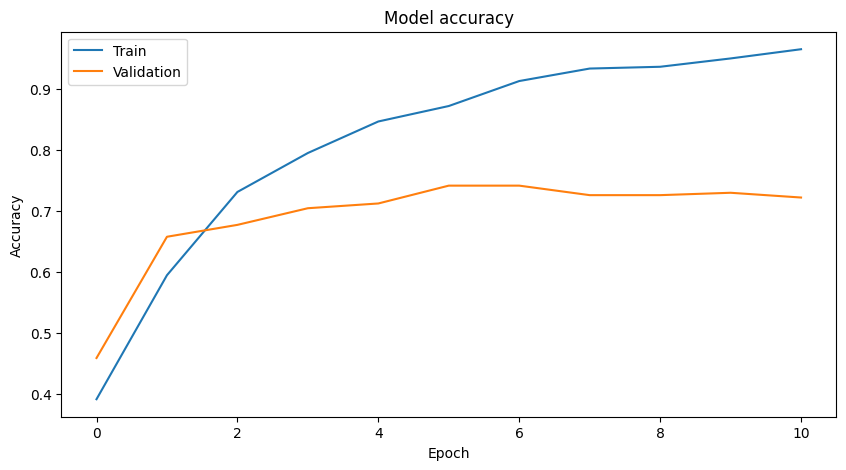

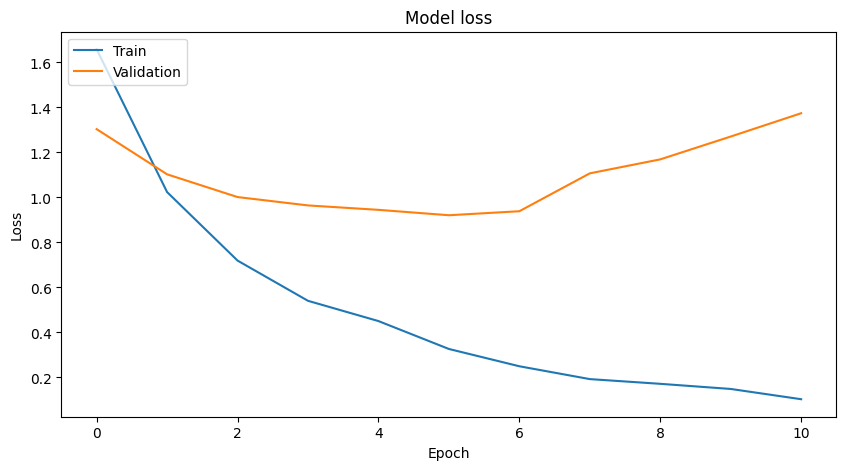

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
import numpy as np

test_labels_single = np.argmax(test_labels, axis=1)
# test_labels contains single-label indicators rather than multilabel indicators. If test_labels is one-hot encoded (indicating multiple classes per sample), you need to convert it to single-label format where each sample has only one correct class.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, test_ds, test_labels):
    y_pred = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Use np.argmax instead of tf.argmax
    accuracy = accuracy_score(test_labels, y_pred_classes)
    precision = precision_score(test_labels, y_pred_classes, average='macro')
    recall = recall_score(test_labels, y_pred_classes, average='macro')
    f1 = f1_score(test_labels, y_pred_classes, average='macro')
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = evaluate_model(model, test_ds, test_labels_single)


35/35 [==============================] - 4s 125ms/step


In [ ]:

print("Transfer Learning Model:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Transfer Learning Model:
Accuracy: 0.9082652134423251
Precision: 0.9099357060716236
Recall: 0.906040035266263
F1 Score: 0.906411703263454


In [ ]:
# Fine-tuning
model.fit(train_ds, train_labels, epochs=20, validation_split=0.2, batch_size=32, callbacks=[earlystop])


base_model.trainable = True

model_ft = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

model_ft.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model_ft.fit(train_ds, train_labels, epochs=20, validation_split=0.2, batch_size=32)

Epoch 1/20
65/65 [==============================] - 6s 93ms/step - loss: 0.2586 - accuracy: 0.9036 - val_loss: 1.1620 - val_accuracy: 0.7082
Epoch 2/20
65/65 [==============================] - 6s 94ms/step - loss: 0.1906 - accuracy: 0.9314 - val_loss: 1.0124 - val_accuracy: 0.7451
Epoch 3/20
65/65 [==============================] - 6s 95ms/step - loss: 0.1917 - accuracy: 0.9387 - val_loss: 1.3089 - val_accuracy: 0.6984
Epoch 4/20
65/65 [==============================] - 6s 97ms/step - loss: 0.1414 - accuracy: 0.9528 - val_loss: 1.2379 - val_accuracy: 0.7179
Epoch 5/20
65/65 [==============================] - 6s 91ms/step - loss: 0.1323 - accuracy: 0.9533 - val_loss: 1.3339 - val_accuracy: 0.7374
Epoch 6/20
65/65 [==============================] - 6s 94ms/step - loss: 0.1065 - accuracy: 0.9635 - val_loss: 1.4155 - val_accuracy: 0.7198
Epoch 7/20
65/65 [==============================] - 6s 89ms/step - loss: 0.0918 - accuracy: 0.9698 - val_loss: 1.3417 - val_accuracy: 0.7471
Epoch 8/20
65

In [ ]:
accuracy, precision, recall, f1 = evaluate_model(model_ft, test_ds, test_labels_single)
print("Transfer Learning Model:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


35/35 [==============================] - 3s 66ms/step
Transfer Learning Model:
Accuracy: 0.7293369663941871
Precision: 0.7374115543345703
Recall: 0.7138662859996623
F1 Score: 0.7073906850804897
